In [646]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import torch
from torch import nn


In [647]:
df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095


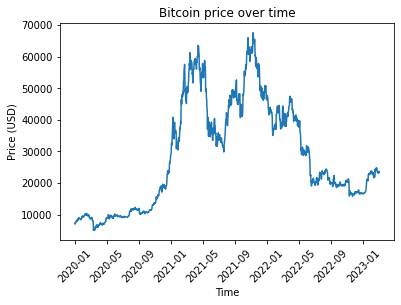

In [648]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.xticks(rotation=45)
plt.show();

In [649]:
ss = StandardScaler()
columns = df.columns
df = ss.fit_transform(df)
df = pd.DataFrame(df, columns=columns)
df

,Open,High,Low,Close,Volume
0,-1.272409,-1.276508,-1.267425,-1.273950,-0.935587
1,-1.271952,-1.278960,-1.282199,-1.286777,-0.815947
2,-1.284971,-1.267242,-1.283449,-1.265305,-0.424921
3,-1.263428,-1.266448,-1.259129,-1.261375,-0.942081
4,-1.259544,-1.259640,-1.253518,-1.261336,-0.873563
...,...,...,...,...,...
1152,-0.318713,-0.323141,-0.286719,-0.296508,-1.038360
1153,-0.295598,-0.311310,-0.279220,-0.298798,-0.716515
1154,-0.297962,-0.327151,-0.287124,-0.321232,-0.830216
1155,-0.320099,-0.309988,-0.286447,-0.291409,-0.609411


In [650]:
test_start = "2022-5-10"
train_data = df.loc[:test_start]
test_data = df.loc[test_start:]

In [651]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1: 
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)
        return x, self.y[i]

In [652]:
target = "Close"
features = ['Open', 'High', 'Low', 'Volume']
torch.manual_seed(101)

batch_size = 4
sequence_length = 30

train_dataset = SequenceDataset(
    train_data,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    test_data,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

In [653]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, features, hidden_units):
        super().__init__()
        self.features = features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [654]:
learning_rate = 5e-5
num_hidden_units = 16

model = TimeSeriesLSTM(features=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [655]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.9445015735920347

Epoch 0
---------
Train loss: 2.114915223682628
Test loss: 0.92396869792488

Epoch 1
---------
Train loss: 2.0407276200313196
Test loss: 0.9032165876445536

Epoch 2
---------
Train loss: 1.963315154991898
Test loss: 0.881868728814027

Epoch 3
---------
Train loss: 1.8827418112287335
Test loss: 0.8596473032249153

Epoch 4
---------
Train loss: 1.7956300833645988
Test loss: 0.8362069431043067

Epoch 5
---------
Train loss: 1.698575501348458
Test loss: 0.8111364187611361

Epoch 6
---------
Train loss: 1.588382833144244
Test loss: 0.7841198795934639

Epoch 7
---------
Train loss: 1.4650155820098578
Test loss: 0.7550199003785432

Epoch 8
---------
Train loss: 1.3252743085225422
Test loss: 0.7236664657456416

Epoch 9
---------
Train loss: 1.1720067952193467
Test loss: 0.6904899183746961

Epoch 10
---------
Train loss: 1.0104041122922711
Test loss: 0.6567787643831084

Epoch 11
---------
Train loss: 0.8511648189787772
Test loss: 0.62429796